In [1]:
import numpy as np
import math
import pandas as pd
import sklearn as sk
import os
import matplotlib
import matplotlib.pyplot as plt
import warnings 
warnings.filterwarnings('ignore')
import seaborn as sns; sns.set_theme()

### Meta Data

In this project, we are predicting the probability that an online transaction is fraudulent, 
as denoted by the binary target isFraud. The data is broken into two files identity and transaction, 
which are joined by TransactionID. Not all transactions have corresponding identity information.

**Transaction Table**

- **TransactionDT**: timedelta from a given reference datetime (not an actual timestamp)
- **TransactionAmt**: transaction payment amount in USD
- **ProductCD**: product code, the product for each transaction
- **card1 - card6**: payment card information, such as card type, card category, issue bank, country, etc.
- **addr1, addr2**: “both addresses are for purchaser; addr1 as billing region; addr2 as billing country”
- **dist: distance**; "distances between (not limited) billing address, mailing address, zip code, IP address, phone area, etc.”
- **P_ and (R__) emaildomain**: purchaser and recipient email domain (certain transactions don't need recipient, so R_emaildomain is null.)
- **C1-C14**: counting, such as how many addresses are found to be associated with the payment card, etc. The actual meaning is masked. (maybe counts of phone numbers, email addresses, names associated with the user, device, ipaddr, billingaddr, etc. Also these are for both purchaser and recipient, which doubles the number.)
- **D1-D15**: timedelta, such as days between previous transaction, etc.
- **M1-M9**: match, such as names on card and address, etc.
- **Vxxx**: Vesta engineered rich features, including ranking, counting, and other entity relations.

**Identity Table**

- **DeviceType**
- **DeviceInfo**
- **id_01 - id_38**
- Variables in this table are identity information – network connection information (IP, ISP, Proxy, etc) and digital signature (UA/browser/os/version, etc) associated with transactions.
- They're collected by Vesta’s fraud protection system and digital security partners.
- The field names are masked and pairwise dictionary will not be provided for privacy protection and contract agreement

In [2]:
#TransactionID - No missing
#isFraud - No missing
#TransactionDT - Time Stamp Data (Will clean later)
#TransactionAmt - No missing
#ProductCD - No missing
#card1 - card6 - Card1: No missing, Card2: 8933, 1.5%, Card3: 1565, 0.26%, Card4: 1577, 0.27%, Card5: 4259, 0.72%, Card6: 1571, 0.27%
#addr1 - addr2 - addr1: 65706, 11.12%, addr2: 65706, 11.12%
#dist1 - dist2 - dist1: 352271, 59.65%, dist2: 552913, 93.62%
#P_emaildomain, R_emaildomain - P_emaildomain: 94456, 15.99%, R_emaildomain: 453249, 76.75%
#C1 - C14 - C1: No missing; C2: No missing; C3: No missing; C4: No missing; C5: No missing; C6: No missing; C7: No missing; C8: No missing; C9: No missing, C10: No missing, C11: No missing, C12: No missing, C13: No missing, C14: No missing;
#D1 - D15
#M1 - M9
#V1 - V339

**Timeline**

- 4/19: Transaction: Cards, addr, dist, email, 
- 4/21: Transaction: D, M
- 4/23: Transaction: V
- 4/25: Identity: Device Type, Device Info
- 4/27: Identity: id_01 - id_38
- 4/28: Done with Feature Selection and Engineering

- Check Column dependency
    - Categorical Columns
        - Group by missing or not, check final label distribution
        - Group by missing or not, check other columns distribution
        - Group by column labels, check other columns distribution

- Filling Missing values for quantitative columns 
    - Compute the correlation between other quantitative columns
    - Graph the scatterplot between the two columns
    - Impute with value prediction based on other columns with large correlation (>=75%)
    - Add a categorical column stating null or not

- Filling Missing values for categorical columns 
    - Add null as a column value
    - TBD
    
- One hot encode
- Standadization/normalization
    - Clip outlier values 

- PCA

### Load Data

In [26]:
#Data path
train_transaction_path = "data/train_transaction.csv"
train_identity_path = "data/train_identity.csv"
# test_transaction_path = "data/test_transaction.csv"
# test_identity_path = "data/test_identity.csv"
# sample_submission_path = "data/sample_submission.csv"

#Read data
train_transaction = pd.read_csv(train_transaction_path)
train_identity = pd.read_csv(train_identity_path)
# test_transaction = pd.read_csv(test_transaction_path)
# test_identity = pd.read_csv(test_identity_path)
# sample_submission = pd.read_csv(sample_submission_path)

train_df = pd.merge(train_identity, train_transaction, on="TransactionID", how='inner')
train_transaction_row = train_transaction.shape[0]
train_transaction_col = train_transaction.shape[1]
train_identity_row = train_identity.shape[0]
train_identity_col = train_identity.shape[1]
train_df_row = train_df.shape[0]
train_df_col = train_df.shape[1]
print('Transaction Training DataFrame: {} rows & {} columns.'.format(train_transaction_row, train_transaction_col))
print('Identity Training DataFrame: {} rows & {} columns.'.format(train_identity_row, train_identity_col))
print('Training DataFrame: {} rows & {} columns.'.format(train_df_row, train_df_col))

Transaction Training DataFrame: 590540 rows & 394 columns.
Identity Training DataFrame: 144233 rows & 41 columns.
Training DataFrame: 144233 rows & 434 columns.


### Categorical Data

In [25]:
identity_col = train_identity.columns
transaction_col = train_transaction.columns
# train_df[train_df.columns[train_df.dtypes==object]].head(2)
# train_transaction[train_transaction.columns[train_transaction.dtypes==object]].head(2)
# train_identity[train_identity.columns[train_identity.dtypes==object]].head(2)
cat_train_df = train_df[train_df.columns[train_df.dtypes==object]]

In [5]:
#returns a table with column name, unique value in each column, and the percentage of unique value in a column
def df_summary_cat(df):
    output = {'col_name': [], 'src': [], 'contain_nan': [], 'unique_val': [], 
              'unique_perc': [], 'null_val': [], 'null_perc': [], 
              'value': [], 'value_perc': [], 'most_common': [], 'redundent_perc': [], 
              'examples': []}

    for i in df.columns:
        unique_val = df[i].nunique()
        if i in identity_col:
            src = 'ID'
        else:
            src = 'TR'
        unique_val_with_nan = len(df[i].unique())
        contain_nan = True if unique_val != unique_val_with_nan else False
        unique_perc = round(unique_val/df.shape[0] * 100, 3)
        null_val = df[i].isnull().sum()
        null_perc = round(null_val / df.shape[0] * 100, 2)
        #The most common value / number of rows
        if len(df[i].value_counts()) > 0:
            redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 2)
        else:
            redundent_perc = 100
        
        value_val = df[i].describe()['count']
        value_perc = round(value_val / df.shape[0] * 100, 2)
        
        examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
        examples = examples_func(unique_val)
        output['col_name'].append(i)
        output['src'].append(src)
        output['contain_nan'].append(contain_nan)
        output['unique_val'].append(unique_val)
        output['unique_perc'].append(str(unique_perc) + '%')
        output['null_val'].append(null_val)
        output['null_perc'].append(str(null_perc) + '%')
        output['redundent_perc'].append(str(redundent_perc) + '%')
        output['value'].append(value_val)
        output['value_perc'].append(str(value_perc) + '%')
        output['most_common'].append(df[i].value_counts().index[0])
        output['examples'].append(examples)
    return pd.DataFrame(output)

In [6]:
cat_train_identity = train_identity[train_identity.columns[train_identity.dtypes==object]]

In [17]:
cat_summary_df = df_summary_cat(cat_train_identity)
cat_summary_df[['col_name', 'unique_val', 'null_perc', 'most_common', 'examples']].sort_values(by=['col_name'], ascending=True)

,col_name,unique_val,null_perc,most_common,examples
16,DeviceInfo,1786,17.73%,Windows,"[Windows, iOS Device, MacOS, Trident/7.0]"
15,DeviceType,2,2.37%,desktop,"[desktop, mobile]"
0,id_12,2,0.0%,NotFound,"[NotFound, Found]"
1,id_15,3,2.25%,Found,"[Found, New, Unknown]"
2,id_16,2,10.33%,Found,"[Found, NotFound]"
3,id_23,3,96.42%,IP_PROXY:TRANSPARENT,"[IP_PROXY:TRANSPARENT, IP_PROXY:ANONYMOUS, IP_..."
4,id_27,2,96.42%,Found,"[Found, NotFound]"
5,id_28,2,2.26%,Found,"[Found, New]"
6,id_29,2,2.26%,Found,"[Found, NotFound]"
7,id_30,75,46.22%,Windows 10,"[Windows 10, Windows 7, iOS 11.2.1, iOS 11.1.2]"


In [8]:
# cat_summary_df = df_summary_cat(cat_train_df)
# cat_summary_df.head(5)

In [9]:
cat_summary_df[cat_summary_df['src']=='ID'].head(100)

,col_name,src,contain_nan,unique_val,unique_perc,null_val,null_perc,value,value_perc,most_common,redundent_perc,examples
0,id_12,ID,False,2,0.001%,0,0.0%,144233,100.0%,NotFound,85.3%,"[NotFound, Found]"
1,id_15,ID,True,3,0.002%,3248,2.25%,140985,97.75%,Found,46.96%,"[Found, New, Unknown]"
2,id_16,ID,True,2,0.001%,14893,10.33%,129340,89.67%,Found,45.98%,"[Found, NotFound]"
3,id_23,ID,True,3,0.002%,139064,96.42%,5169,3.58%,IP_PROXY:TRANSPARENT,2.42%,"[IP_PROXY:TRANSPARENT, IP_PROXY:ANONYMOUS, IP_..."
4,id_27,ID,True,2,0.001%,139064,96.42%,5169,3.58%,Found,3.57%,"[Found, NotFound]"
5,id_28,ID,True,2,0.001%,3255,2.26%,140978,97.74%,Found,52.85%,"[Found, New]"
6,id_29,ID,True,2,0.001%,3255,2.26%,140978,97.74%,Found,51.95%,"[Found, NotFound]"
7,id_30,ID,True,75,0.052%,66668,46.22%,77565,53.78%,Windows 10,14.67%,"[Windows 10, Windows 7, iOS 11.2.1, iOS 11.1.2]"
8,id_31,ID,True,130,0.09%,3951,2.74%,140282,97.26%,chrome 63.0,15.25%,"[chrome 63.0, mobile safari 11.0, mobile safar..."
9,id_33,ID,True,260,0.18%,70944,49.19%,73289,50.81%,1920x1080,11.7%,"[1920x1080, 1366x768, 1334x750, 2208x1242]"


### Quantitative Data

In [10]:
# quant_train_df = train_df[train_df.columns[train_df.dtypes!=object]]

In [18]:
quant_train_df = train_identity[train_identity.columns[train_identity.dtypes!=object]]

In [19]:
def df_summary_quan(df):
    output = {'col_name': [], 'src': [], 'contain_nan': [], 'unique_val': [], 
              'unique_perc': [], 'null_val': [], 'null_perc': [], 'redundent_perc': [],
              'value': [], 'value_perc': [], 'mean': [], 'max': [], 'min': [], 'std': [], 
              '25%': [], '50%': [], '75%': [], 'examples': []}

    for i in df.columns:
        unique_val = df[i].nunique()
        if i in identity_col:
            src = 'ID'
        else:
            src = 'TR'
        unique_val_with_nan = len(df[i].unique())
        contain_nan = True if unique_val != unique_val_with_nan else False
        unique_perc = round(unique_val/df.shape[0] * 100, 3)
        null_val = df[i].isnull().sum()
        null_perc = round(null_val / df.shape[0] * 100, 3)
        if len(df[i].value_counts()) > 0:
            redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 3)
        else:
            redundent_perc = 100
        
        value_val = df[i].describe()['count']
        value_perc = round(value_val / df.shape[0] * 100, 2)
        mean_val = df[i].describe()['mean']
        std_val = df[i].describe()['std']
        min_val = df[i].describe()['min']
        twenty_five = df[i].describe()['25%']
        fifty = df[i].describe()['50%']
        seventy_five = df[i].describe()['75%']
        max_val = df[i].describe()['max']
        
        examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
        examples = examples_func(unique_val)
        output['col_name'].append(i)
        output['src'].append(src)
        output['unique_val'].append(unique_val)
        output['contain_nan'].append(contain_nan)
        output['unique_perc'].append(unique_perc)
        output['null_val'].append(null_val)
        output['null_perc'].append(null_perc)
        output['redundent_perc'].append(redundent_perc)
        output['value'].append(value_val)
        output['value_perc'].append(value_perc)
        output['mean'].append(round(mean_val, 2))        
        output['max'].append(max_val)        
        output['min'].append(min_val)
        output['std'].append(std_val)
        output['25%'].append(twenty_five)
        output['50%'].append(fifty)
        output['75%'].append(seventy_five)
        output['examples'].append(examples)
    return pd.DataFrame(output)

In [23]:
quan_summary_df = df_summary_quan(quant_train_df).sort_values('col_name', ascending=True)
quan_summary_df[['col_name', 'unique_val', 'null_perc', 'min', 'max', 'examples']].head(40)

,col_name,unique_val,null_perc,min,max,examples
0,TransactionID,144233,0.000,2987004.0,3577534.0,"[3147777, 3035935, 3552019, 3015445]"
1,id_01,77,0.000,-100.0,0.0,"[-5.0, 0.0, -10.0, -20.0]"
2,id_02,115655,2.330,1.0,999595.0,"[1102.0, 696.0, 1117.0, 1083.0]"
3,id_03,24,54.016,-13.0,10.0,"[0.0, 1.0, 3.0, 2.0]"
4,id_04,15,54.016,-28.0,0.0,"[0.0, -5.0, -6.0, -8.0]"
5,id_05,93,5.108,-72.0,52.0,"[0.0, 1.0, 2.0, 3.0]"
6,id_06,101,5.108,-100.0,0.0,"[0.0, -1.0, -5.0, -6.0]"
7,id_07,84,96.426,-46.0,61.0,"[0.0, 16.0, 14.0, 12.0]"
8,id_08,94,96.426,-100.0,0.0,"[-100.0, 0.0, -34.0, -33.0]"
9,id_09,46,48.052,-36.0,25.0,"[0.0, 1.0, 3.0, 2.0]"


In [11]:
train_transaction['M1'].value_counts()

T    319415
F        25
Name: M1, dtype: int64

In [12]:
train_transaction[train_transaction['M9'] == 'F']['isFraud'].mean()

0.03000103541105819

In [13]:
train_transaction[train_transaction['M9'] == 'T']['isFraud'].mean()

0.01778698408993659

In [14]:
train_transaction[train_transaction['M9'].isnull() == True]['isFraud'].mean()

0.04576435659577418

In [15]:
train_transaction['isFraud'].mean()

0.03499000914417313

<AxesSubplot:>

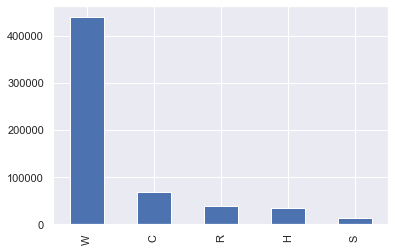

In [16]:
train_transaction['ProductCD'].value_counts().plot.bar()

<AxesSubplot:>

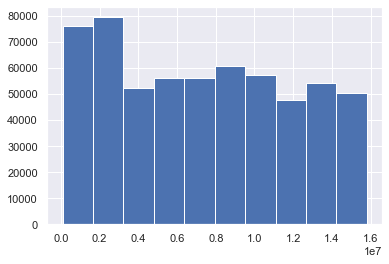

In [17]:
train_transaction['TransactionDT'].hist()

In [41]:
train_transaction.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt',
       'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5',
       ...
       'shuffle_M5', 'shuffle_M6', 'shuffle_M7', 'shuffle_M8', 'shuffle_M9',
       'shuffle_V1', 'shuffle_V2', 'shuffle_V3', 'shuffle_V4', 'shuffle_V5'],
      dtype='object', length=434)

In [40]:
quan_summary_df[quan_summary_df['src']=='TR'].sort_values('col_name', ascending=False)[['col_name', 'null_perc', 'unique_val', 'unique_perc']].tail(35)

,col_name,null_perc,unique_val,unique_perc
164,V101,0.053,870,0.147
163,V100,0.053,29,0.005
73,V10,47.293,5,0.001
64,V1,47.293,2,0.000
25,TransactionDT,0.000,573349,97.089
26,TransactionAmt,0.000,20902,3.539
57,D9,87.312,24,0.004
56,D8,87.312,12353,2.092
55,D7,93.410,597,0.101
54,D6,87.607,829,0.140


In [39]:
train_transaction.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to shuffle_V5
dtypes: float64(403), int64(4), object(27)
memory usage: 1.9+ GB


### EDA

In [20]:
# pd.set_option('display.max_rows', None)
# cat_tr = cat_summary_df[cat_summary_df['src']=='TR'][['col_name', 'null_val', 'null_perc', 'examples']]
# quan_tr = quan_summary_df[quan_summary_df['src']=='TR'][['col_name', 'null_val', 'null_perc', 'examples']]
# tr_summary = pd.concat([cat_tr, quan_tr])
# tr_summary.sort_values(by=['col_name'])

In [21]:
# #card1
# tr_summary[tr_summary['col_name']=='card2']

In [22]:
train_transaction['card1'].isnull().mean()

0.0

In [23]:
train_transaction['addr1'].value_counts()

299.0    46335
325.0    42751
204.0    42020
264.0    39870
330.0    26287
         ...  
137.0        1
451.0        1
463.0        1
195.0        1
467.0        1
Name: addr1, Length: 332, dtype: int64

In [24]:
train_transaction['addr2'].value_counts()

87.0    520481
60.0      3084
96.0       638
32.0        91
65.0        82
         ...  
50.0         1
15.0         1
25.0         1
82.0         1
22.0         1
Name: addr2, Length: 74, dtype: int64

### Hypothesis Testing (Missing at random)

In [71]:
def hypo_test_missing(col_name, data):
    #Compute observed statistics
    col_name_missing = col_name + '_missing'
    missing_df = data[[col_name, 'isFraud']]
    missing_df[col_name_missing] = missing_df[col_name].isnull()
    missing_df = pd.DataFrame(missing_df.groupby([col_name_missing])['isFraud'].value_counts(normalize=True)).rename(columns={'isFraud':'isFraud_count'})
    missing_df.reset_index(inplace=True)
    missing_df=missing_df.pivot(index=col_name_missing, columns='isFraud', values='isFraud_count')
    #missing_df.plot.barh(stacked=True)
    #display(missing_df)
    observed_stats = missing_df[0][0] - missing_df[0][1]
    
    #Permutation Test
    def permutation(col_name, data):
        output = []
        for _ in range(100):
            shuffle_col_name = 'shuffle_' + col_name
            col_name_missing = col_name + '_missing'
            shuffle_col_name_missing = shuffle_col_name + '_missing'
            data[shuffle_col_name] = data[col_name].sample(frac=1, replace=False).reset_index()[col_name]
            missing_df = data[[shuffle_col_name, 'isFraud']]
            missing_df[shuffle_col_name_missing] = missing_df[shuffle_col_name].isnull()
            missing_df = pd.DataFrame(missing_df.groupby([shuffle_col_name_missing])['isFraud'].value_counts(normalize=True)).rename(columns={'isFraud':'isFraud_count'})
            missing_df.reset_index(inplace=True)
            missing_df=missing_df.pivot(index=shuffle_col_name_missing, columns='isFraud', values='isFraud_count')
            output.append(missing_df[0][0] - missing_df[0][1])
        return output

    expected_stats = permutation(col_name, data)
    title = col_name + 'missing at random'
    if observed_stats < (sum(expected_stats)/len(expected_stats)):
        p_value = (expected_stats <= observed_stats).mean()
    else:
        p_value = (expected_stats >= observed_stats).mean()
    
    if p_value < 0.05:
        print('The column ' + col_name + ' is not missing at random.')
        missing = "Not Missing At Random"
    else:
        print('The column ' + col_name + ' is missing at random.')
        missing = "Missing At Random"
    return expected_stats, observed_stats, p_value, missing

In [59]:
tr_col = ['id_01', 'id_02', 'id_03', 'id_04', 'id_05', 'id_06',
       'id_07', 'id_08', 'id_09', 'id_10', 'id_11', 'id_12', 'id_13', 'id_14',
       'id_15', 'id_16', 'id_17', 'id_18', 'id_19', 'id_20', 'id_21', 'id_22',
       'id_23', 'id_24', 'id_25', 'id_26', 'id_27', 'id_28', 'id_29', 'id_30',
       'id_31', 'id_32', 'id_33', 'id_34', 'id_35', 'id_36', 'id_37', 'id_38',
       'DeviceType', 'DeviceInfo']

In [68]:
def missing_at_random(data, col):
    missing_dic = {'Column': [], 'Expected_Stats': [], 'Observed_Stats': [], 'p_value': [], 'Missing': []}
    for i in col:
        missing_dic['Column'].append(i)
        if data[i].isnull().sum() == 0:
            print('The column ' + i + ' does not contain any missing values.')
            missing_dic['Expected_Stats'].append('NA')
            missing_dic['Observed_Stats'].append('NA')
            missing_dic['p_value'].append('NA')
            missing_dic['Missing'].append('NA')
        else:
            expected_stats, observed_stats, p_value, missing = hypo_test_missing(i, data)
            missing_dic['Expected_Stats'].append(expected_stats)
            missing_dic['Observed_Stats'].append(observed_stats)
            missing_dic['p_value'].append(p_value)
            missing_dic['Missing'].append(missing)
    missing_df = pd.DataFrame(missing_dic)
    return missing_df

In [61]:
# tr_col = ['P_emaildomain' , 'R_emaildomain']

In [62]:
# list(train_transaction.columns)
tr_col

In [72]:
missing_df = missing_at_random(train_df, tr_col)
missing_df

The column id_01 does not contain any missing values.
The column id_02 is not missing at random.
The column id_03 is not missing at random.
The column id_04 is not missing at random.
The column id_05 is not missing at random.
The column id_06 is not missing at random.
The column id_07 is missing at random.
The column id_08 is missing at random.
The column id_09 is not missing at random.
The column id_10 is not missing at random.
The column id_11 is not missing at random.
The column id_12 does not contain any missing values.
The column id_13 is not missing at random.
The column id_14 is not missing at random.
The column id_15 is not missing at random.
The column id_16 is missing at random.
The column id_17 is not missing at random.
The column id_18 is not missing at random.
The column id_19 is not missing at random.
The column id_20 is not missing at random.
The column id_21 is missing at random.
The column id_22 is missing at random.
The column id_23 is missing at random.
The column id

,Column,Expected_Stats,Observed_Stats,p_value,Missing
0,id_01,NA,NA,NA,NA
1,id_02,"[-0.001443491365355487, -0.004489782761509908,...",-0.051098,0.0,Not Missing At Random
2,id_03,"[-0.0003220862824542259, 0.0024133863354978136...",-0.053245,0.0,Not Missing At Random
3,id_04,"[-0.002610951126046812, -0.0006291291273263777...",-0.053245,0.0,Not Missing At Random
4,id_05,"[0.0012631099469415652, 0.0006909959023873036,...",-0.034637,0.0,Not Missing At Random
5,id_06,"[0.0009770529246644344, -0.0035998594317701027...",-0.034637,0.0,Not Missing At Random
6,id_07,"[-0.001908330501766864, 0.0031210852672545197,...",-0.004322,0.12,Missing At Random
7,id_08,"[0.005132851574863095, -0.012771868562853061, ...",-0.004322,0.14,Missing At Random
8,id_09,"[0.0019848661402555035, 0.0013460397859723638,...",-0.054093,0.0,Not Missing At Random
9,id_10,"[0.0022070666113104265, -0.0004037889235855019...",-0.054093,0.0,Not Missing At Random


In [73]:
missing_df_missing = missing_df[missing_df['Expected_Stats'] != 'NA']
col = list(missing_df_missing.Column)

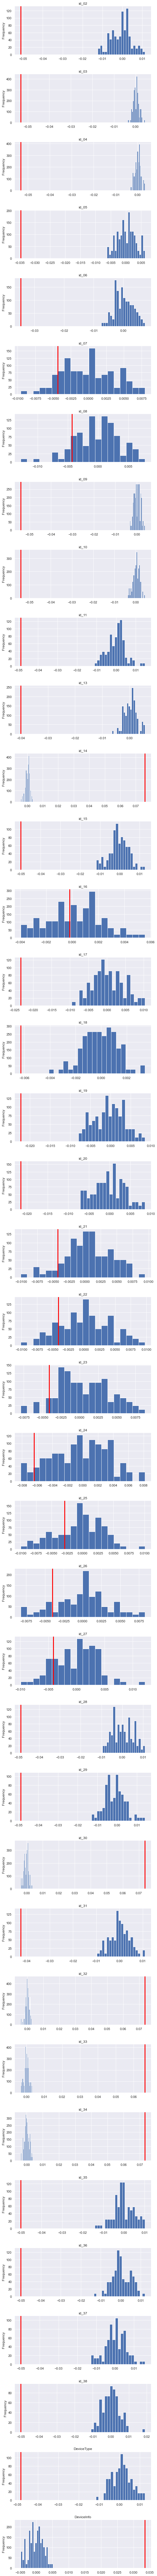

In [74]:
fig = plt.figure(figsize=(8,150))
for i in range(0, len(col)):
    ax = fig.add_subplot(len(col),1,i+1)
    expected_stats = pd.Series(missing_df[missing_df['Column'] == col[i]]['Expected_Stats'].values[0])
    observed_stats = missing_df[missing_df['Column'] == col[i]]['Observed_Stats'].values[0]
    ax = expected_stats.plot(kind='hist', density=True, ec='w', bins=20, title=col[i])
    plt.axvline(x=observed_stats, color='red', linewidth=3);
    plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9,
                    wspace=0.4, 
                    hspace=0.4)
plt.show()

In [31]:
train_transaction[['D1']].value_counts()

D1   
0.0      280130
1.0        8634
2.0        4969
3.0        3954
4.0        3570
          ...  
621.0       109
619.0       107
638.0        79
639.0        42
640.0        14
Length: 641, dtype: int64

### Compute Column Dependency

In [6]:
tr_quan_cols = train_transaction.columns[train_transaction.dtypes != object]

In [7]:
tr_df = train_transaction[tr_quan_cols]

In [8]:
tr_df.columns

Index(['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'card1',
       'card2', 'card3', 'card5', 'addr1', 'addr2',
       ...
       'V330', 'V331', 'V332', 'V333', 'V334', 'V335', 'V336', 'V337', 'V338',
       'V339'],
      dtype='object', length=380)

In [9]:
tr_df.drop(columns=['TransactionID', 'isFraud', 'TransactionDT'], inplace=True)

In [11]:
tr_df.iloc[:, 0:50]

,TransactionAmt,card1,card2,card3,card5,addr1,addr2,dist1,dist2,C1,...,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12
0,68.50,13926,NaN,150.0,142.0,315.0,87.0,19.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
1,29.00,2755,404.0,150.0,102.0,325.0,87.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0
2,59.00,4663,490.0,150.0,166.0,330.0,87.0,287.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
3,50.00,18132,567.0,150.0,117.0,476.0,87.0,NaN,NaN,2.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
4,50.00,4497,514.0,150.0,102.0,420.0,87.0,NaN,NaN,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
590535,49.00,6550,NaN,150.0,226.0,272.0,87.0,48.0,NaN,2.0,...,1.0,0.0,0.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0
590536,39.50,10444,225.0,150.0,224.0,204.0,87.0,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0
590537,30.95,12037,595.0,150.0,224.0,231.0,87.0,NaN,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0
590538,117.00,7826,481.0,150.0,224.0,387.0,87.0,3.0,NaN,1.0,...,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,1.0


<AxesSubplot:>

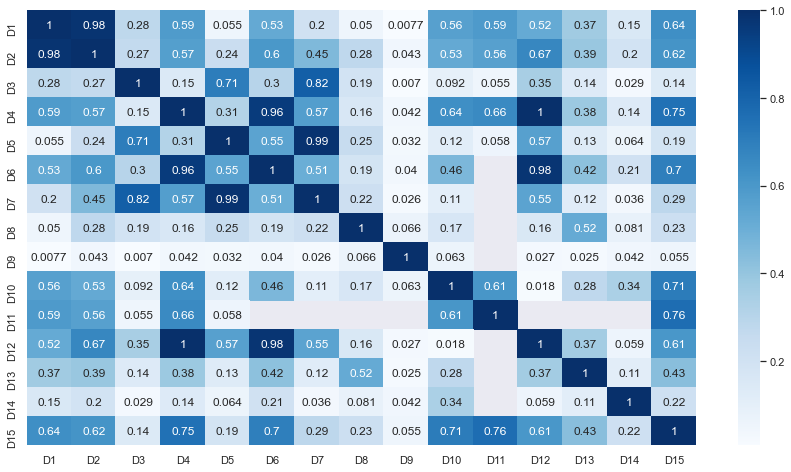

In [22]:
import seaborn as sb
sns.set(rc = {'figure.figsize':(15,8)})
corr = tr_df.iloc[:, 23:38].corr()
sb.heatmap(corr, cmap="Blues", annot=True)

### Filter Columns

In [10]:
# #returns a table with column name, unique value in each column, and the percentage of unique value in a column
# def df_summary(df):
#     output = {'col_name': [], 'src': [], 'dtype' : [], 'unique_val': [], 'contain_nan': [],
#               'unique_perc': [], 'null_val': [], 'null_perc': [], 'redundent_perc': [],
#               'count': [], 'mean': [], 'max': [], 'min': [], 'std': [], 
#               '25%': [], '50%': [], '75%': [], 'examples': []}

#     for i in df.columns:
#         unique_val = df[i].nunique()
#         if i in identity_col:
#             src = 'ID'
#         else:
#             src = 'TR'
#         unique_val_with_nan = len(df[i].unique())
#         contain_nan = True if unique_val != unique_val_with_nan else False
#         unique_perc = round(unique_val/df.shape[0] * 100, 3)
#         null_val = df[i].isnull().sum()
#         null_perc = round(null_val / df.shape[0] * 100, 3)
#         if len(df[i].value_counts()) > 0:
#             redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 3)
#         else:
#             redundent_perc = 100
        
#         if df[i].dtype == 'float64':
#             count_val = df[i].describe()['count']
#             mean_val = df[i].describe()['mean']
#             std_val = df[i].describe()['std']
#             min_val = df[i].describe()['min']
#             twenty_five = df[i].describe()['25%']
#             fifty = df[i].describe()['50%']
#             seventy_five = df[i].describe()['75%']
#             max_val = df[i].describe()['max']
#         else:
#             count_val = np.nan
#             mean_val = np.nan
#             std_val = np.nan
#             min_val = np.nan
#             twenty_five = np.nan
#             fifty = np.nan
#             seventy_five = np.nan
#             max_val = np.nan
        
#         examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
#         examples = examples_func(unique_val)
#         output['col_name'].append(i)
#         output['src'].append(src)
#         output['dtype'].append(df[i].dtype)
#         output['unique_val'].append(unique_val)
#         output['contain_nan'].append(contain_nan)
#         output['unique_perc'].append(unique_perc)
#         output['null_val'].append(null_val)
#         output['null_perc'].append(null_perc)
#         output['redundent_perc'].append(redundent_perc)
#         output['count'].append(count_val)
#         output['mean'].append(mean_val)        
#         output['max'].append(max_val)
#         output['min'].append(min_val)
#         output['std'].append(std_val)
#         output['25%'].append(twenty_five)
#         output['50%'].append(fifty)
#         output['75%'].append(seventy_five)
#         output['examples'].append(examples)
#     return pd.DataFrame(output)

In [11]:
# summary_df = df_summary(train_df)
# summary_df.head(5)

In [12]:
# #Drop columns contains > 90% null observations
# print("Null Value Percent > 90%: {} Columns".format(summary_df[(summary_df['null_perc']>90)].shape[0]))
# #Drop columns contains > 90% redundent information
# print("Redundent Percent > 90%: {} Columns".format(summary_df[(summary_df['redundent_perc']>90)].shape[0]))
# #Drop columns contains > 90% null observations
# #Drop columns contains > 90% redundent information

# summary_df_clean = summary_df[(summary_df['null_perc']<=90) & (summary_df['redundent_perc']<=90)]
# summary_df_clean.sort_values('null_perc', ascending=False)
# summary_df[summary_df['redundent_perc']>=90] #redundent_perc > 90 && unique value < ???
# summary_df[summary_df['unique_val']<2]
# train_identity_box_df = train_identity.drop(columns=['TransactionID', 'id_02'])
# train_identity.head(2)
# train_transaction.head(2)

In [13]:
# train_transaction[['D1']].hist(bins=100)
# uniform_data = np.random.rand(10, 12)



# c_data = train_transaction[['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14']]
# c_pear_corr=c_data.corr(method='pearson')
# c_pear_corr

# d_data = train_transaction[['D1', 'D2', 'D3', 'D4', 'D5', 'D6', 'D7', 'D8', 'D9', 'D10', 'D11', 'D12', 'D13', 'D14', 'D15']]
# d_pear_corr=d_data.corr(method='pearson')
# d_pear_corr

# fig, ax = plt.subplots(figsize=(8,8))
# im = ax.imshow(c_pear_corr, interpolation='nearest')
# fig.colorbar(im, orientation='vertical', fraction = 0.05)



# fig, ax = plt.subplots(figsize=(8,8))
# im = ax.imshow(d_pear_corr, interpolation='nearest')
# fig.colorbar(im, orientation='vertical', fraction = 0.05)




# fig, ax = plt.subplots(figsize=(16,16))
# im = ax.imshow(pear_corr, interpolation='nearest')
# fig.colorbar(im, orientation='vertical', fraction = 0.05)

# # Show all ticks and label them with the dataframe column name
# ax.set_xticklabels(our_data.columns, rotation=65, fontsize=20)
# ax.set_yticklabels(our_data.columns, rotation=0, fontsize=20)

# # Loop over data dimensions and create text annotations
# for i in range(len(our_data.columns)-1):
#     for j in range(len(our_data.columns)-1):
#         text = ax.text(j, i, round(pear_corr.to_numpy()[i, j], 2),
#                        ha="center", va="center", color="black")

# plt.show()

In [14]:
# pd.set_option('display.max_rows', None)
# cat_tr = cat_summary_df[cat_summary_df['src']=='TR'][['col_name', 'null_val', 'null_perc', 'examples']]
# quan_tr = quan_summary_df[quan_summary_df['src']=='TR'][['col_name', 'null_val', 'null_perc', 'examples']]
# tr_summary = pd.concat([cat_tr, quan_tr])
# tr_summary.sort_values(by=['col_name'])

In [ ]:
#returns a table with column name, unique value in each column, and the percentage of unique value in a column
def df_summary_cat(df):
    output = {'col_name': [], 'src': [], 'dtype' : [], 'unique_val': [], 'contain_nan': [],
              'unique_perc': [], 'null_val': [], 'null_perc': [], 'redundent_perc': [],
              'count': [], 'mean': [], 'max': [], 'min': [], 'std': [], 
              '25%': [], '50%': [], '75%': [], 'examples': []}

    for i in df.columns:
        unique_val = df[i].nunique()
        if i in identity_col:
            src = 'ID'
        else:
            src = 'TR'
        unique_val_with_nan = len(df[i].unique())
        contain_nan = True if unique_val != unique_val_with_nan else False
        unique_perc = round(unique_val/df.shape[0] * 100, 3)
        null_val = df[i].isnull().sum()
        null_perc = round(null_val / df.shape[0] * 100, 3)
        if len(df[i].value_counts()) > 0:
            redundent_perc = round(df[i].value_counts().iloc[0] / df.shape[0] * 100, 3)
        else:
            redundent_perc = 100
        
        if df[i].dtype == 'float64':
            count_val = df[i].describe()['count']
            mean_val = df[i].describe()['mean']
            std_val = df[i].describe()['std']
            min_val = df[i].describe()['min']
            twenty_five = df[i].describe()['25%']
            fifty = df[i].describe()['50%']
            seventy_five = df[i].describe()['75%']
            max_val = df[i].describe()['max']
        else:
            count_val = np.nan
            mean_val = np.nan
            std_val = np.nan
            min_val = np.nan
            twenty_five = np.nan
            fifty = np.nan
            seventy_five = np.nan
            max_val = np.nan
        
        examples_func = lambda x : list(df[i].value_counts().index) if (x <= 4) else list(df[i].value_counts().index[:4])
        examples = examples_func(unique_val)
        output['col_name'].append(i)
        output['src'].append(src)
        output['dtype'].append(df[i].dtype)
        output['unique_val'].append(unique_val)
        output['contain_nan'].append(contain_nan)
        output['unique_perc'].append(unique_perc)
        output['null_val'].append(null_val)
        output['null_perc'].append(null_perc)
        output['redundent_perc'].append(redundent_perc)
        output['count'].append(count_val)
        output['mean'].append(mean_val)        
        output['max'].append(max_val)        
        output['min'].append(min_val)
        output['std'].append(std_val)
        output['25%'].append(twenty_five)
        output['50%'].append(fifty)
        output['75%'].append(seventy_five)
        output['examples'].append(examples)
    return pd.DataFrame(output)